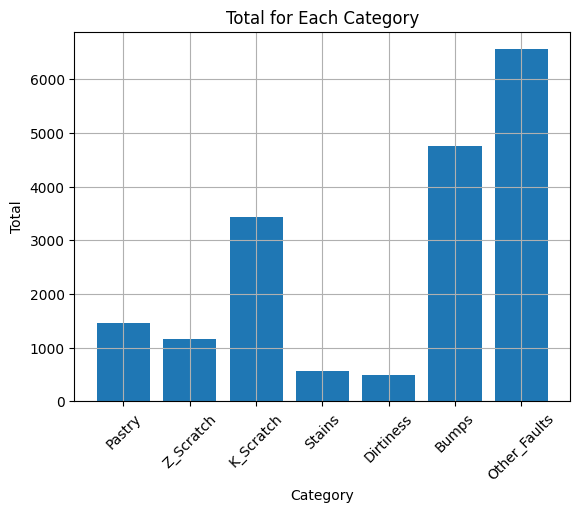

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from scipy.stats import randint
import matplotlib.pyplot as plt
train= pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

train.head()
train.rename(columns={'K_Scatch' : 'K_Scratch'}, inplace = True)

#Understanding the data

df = train.iloc[:,-7:]

category_sums = df.sum()

# Plot histogram
plt.bar(category_sums.index, category_sums.values)
plt.xlabel('Category')
plt.ylabel('Total')
plt.title('Total for Each Category')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [2]:

#preparing the data for modeling
pastry = train.drop(columns= ['Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
zScratch = train.drop(columns= ['Pastry', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
kScratch = train.drop(columns= ['Z_Scratch', 'Pastry', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
stains = train.drop(columns= ['Z_Scratch', 'K_Scratch', 'Pastry', 'Dirtiness', 'Bumps', 'Other_Faults'])
dirtiness = train.drop(columns= ['Z_Scratch', 'K_Scratch', 'Stains', 'Pastry', 'Bumps', 'Other_Faults'])
bumps = train.drop(columns= ['Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Pastry', 'Other_Faults'])
otherFaults = train.drop(columns= ['Z_Scratch', 'K_Scratch', 'Stains', 'Dirtiness', 'Bumps', 'Pastry'])



faults = [pastry,zScratch,kScratch,stains,dirtiness,bumps,otherFaults]
for fault_df in faults:
    last_col = fault_df.shape[1] - 1


    fault_df['Name'] = fault_df.columns[-1]

    

    fault_df.rename(columns={fault_df.columns[last_col]: 'fault'}, inplace = True)

In [3]:
# #Seeing how well a random forest does on each individual fault


# results = {}

# for fault_df in faults:
#     fault_name = fault_df['Name'].iloc[0]  # Get the value of the 'Name' column for the first row
#     fault_df.drop(columns=['Name'], inplace=True)
    
#     X  = fault_df.drop(columns={'fault'})
#     y = fault_df['fault'] 

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    

#     param_dist = {'n_estimators': randint(50,500),
#               'max_depth': randint(1,20)}


#     rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter = 5, cv= 5)

#     rand_search.fit(X_train,y_train)
    
#     best_params = rand_search.best_params_
#     print('Best hyperparameters for ' + fault_name + ': ' + str(best_params))
    
    
#     tuned_rf = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth= best_params['max_depth']) 
#     tuned_rf.fit(X_train,y_train)
#     y_pred = tuned_rf.predict(X_test)

#     cv_preds = cross_val_predict(tuned_rf, X, y, cv = 5, n_jobs=-1, method='predict_proba')

    
#     score = roc_auc_score(y_true=y, y_score = cv_preds[:,1])
    
#     print(f" {fault_df} roc-auc score: {score:0.3f}")

#     accuracy = accuracy_score(y_test, y_pred)
    
#     print(fault_name + ' Prediction accuracy: ' + str(accuracy))

    

#     results[fault_name] = {'Accuracy': accuracy,'Score': score , 'y_test': y_test, 'y_pred': y_pred}

# avg = (results['Bumps']['Accuracy'] + results['K_Scratch']['Accuracy'] + results['Dirtiness']['Accuracy'] + results['Z_Scratch']['Accuracy'] + results['Stains']['Accuracy'] + results['Other_Faults']['Accuracy'] + results['Pastry']['Accuracy']) / 7
# print('Overall Average Accuracy: ' + str(avg))

c:\Python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


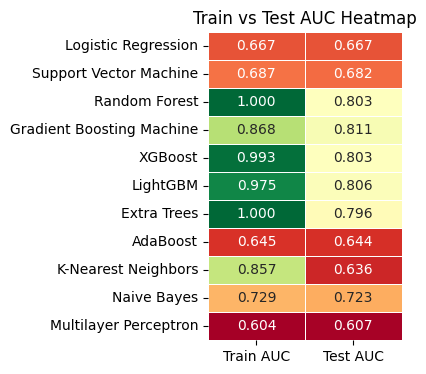

In [4]:
#doing main preliminary modeling



import seaborn as sns

TARGETS = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Dirtiness','Stains', 'Bumps', 'Other_Faults']     

CLASSIFIERS = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Machine": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Multilayer Perceptron": MLPClassifier()
}




X = train.drop(columns=TARGETS)
#y = train[TARGETS]


#use this y for predict_proba
y = np.argmax(train[TARGETS],axis = 1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=97)


#Have to use predict probability for the AUC 
results = {}

for name, clf in CLASSIFIERS.items():
    clf.fit(X_train,y_train)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)

    train_auc = roc_auc_score(y_train, train_proba, average='weighted', multi_class='ovr')
    test_auc = roc_auc_score(y_test, test_proba, average='weighted', multi_class='ovr')

    results[name] = {'Train AUC': train_auc, 'Test AUC': test_auc}

results_df = pd.DataFrame([(name, scores['Train AUC'], scores['Test AUC']) for name, scores in results.items()], columns=['Classifier', 'Train AUC', 'Test AUC'])




plt.figure(figsize=(2.5, 4))
sns.heatmap(results_df.set_index('Classifier'), cmap='RdYlGn', cbar=False, annot=True, fmt=".3f", linewidths=.5)
plt.title('Train vs Test AUC Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.show()


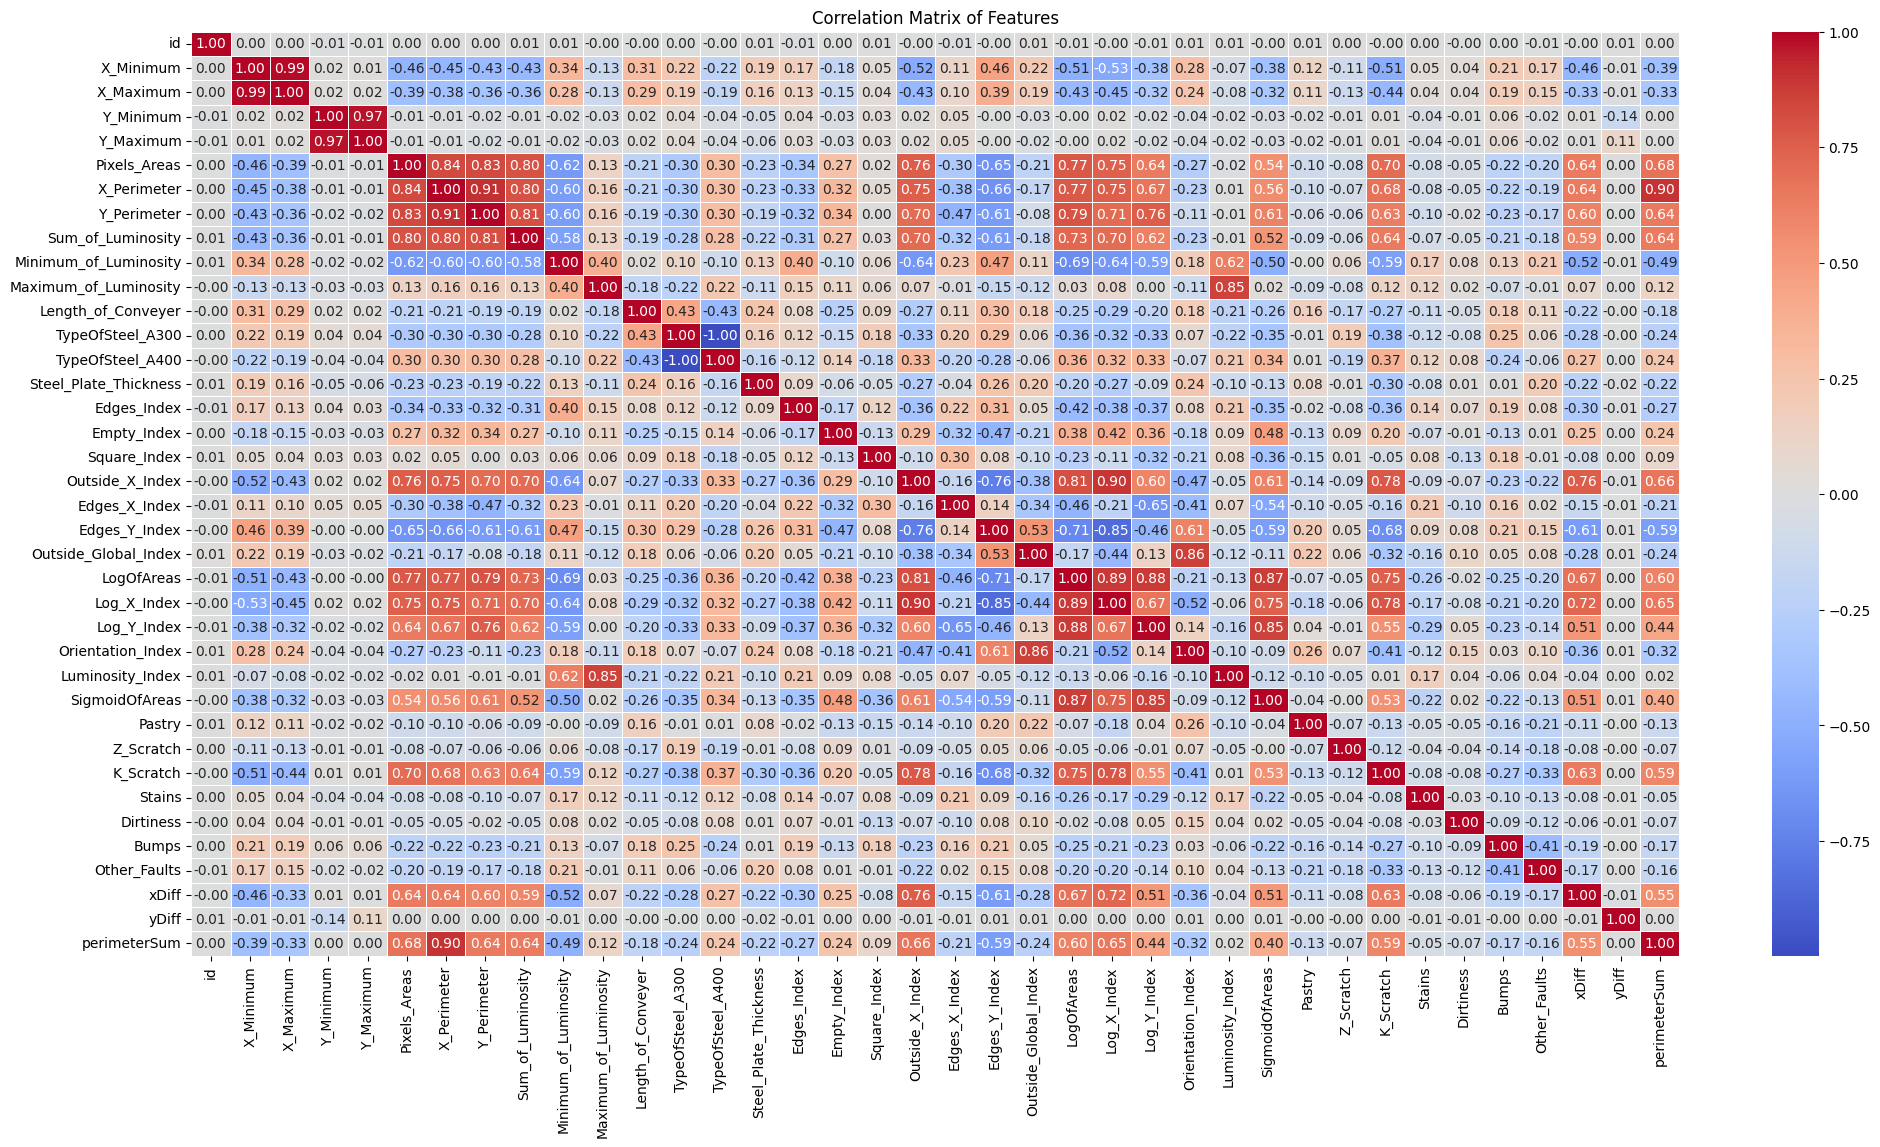

In [5]:
#We can see here that going with one of the boost methods would be best, not the trees which have high scores most likely due to overfitting



#Doing some feature_engineering to try to improve our model
train['xDiff'] = train['X_Maximum'] - train['X_Minimum']
train['yDiff'] = train['Y_Maximum'] - train['Y_Minimum']
train['perimeterSum'] = train['X_Perimeter'] - train['Y_Perimeter']
corr = train.corr()

plt.figure(figsize=(24, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()


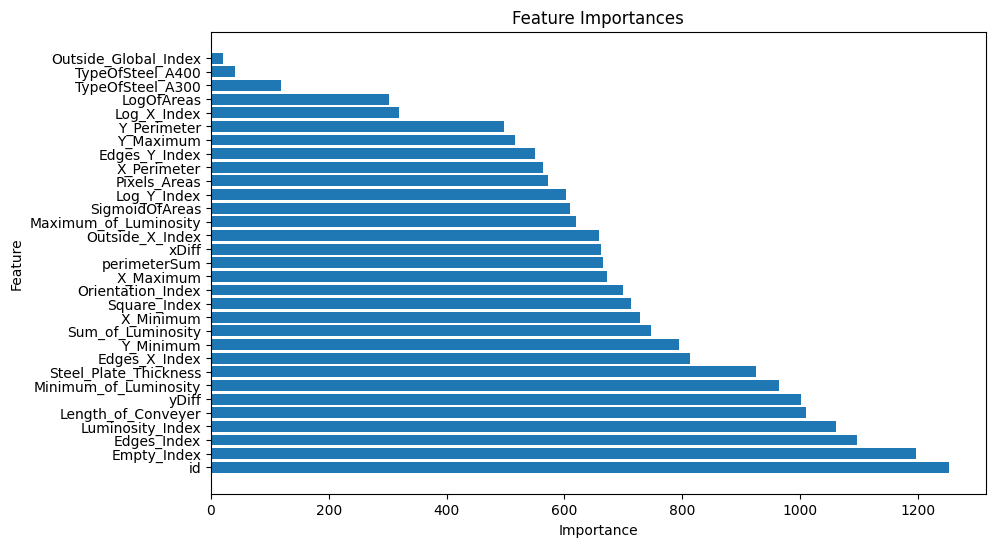

In [6]:
X=train.drop(columns= TARGETS)


lgbm = LGBMClassifier(verbose=-1)

# Fit the model
lgbm.fit(X, y)  

# Get feature importances
feature_importance = lgbm.feature_importances_

# store feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [7]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd


train = train.drop(columns = {'Outside_Global_Index', 'TypeOfSteel_A400', 'TypeOfSteel_A300', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Maximum_of_Luminosity', 'X_Perimeter', 'Y_Perimeter','id','SigmoidOfAreas'})
X= train.drop(columns = TARGETS)

# Define LightGBM classifier only
CLASSIFIERS = {
    "LightGBM": LGBMClassifier(verbose=-1),
}


TARGETS = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Dirtiness', 'Stains', 'Bumps', 'Other_Faults']    


X = train.drop(columns=TARGETS)

#Initialize dictionaries to store accuracies and best hyperparameters
train_accuracies = {name: [] for name in CLASSIFIERS}
test_accuracies = {name: [] for name in CLASSIFIERS}
best_params = {name: {} for name in CLASSIFIERS}

#Iterate over each target column
for target_col in TARGETS:
    y = train[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=97)

    for name, clf in CLASSIFIERS.items():
        #Defining parameter grid for hyperparameter tuning
        param_grid = {
            'num_leaves': [20, 30, 40],  # Number of leaves in each tree
            'max_depth': [5, 10, 15],     # Maximum depth of each tree
            'learning_rate': [0.05, 0.1, 0.2],  # Learning rate (shrinkage)
            'min_child_samples': [20, 50, 100]  # Minimum number of samples required to form a leaf
        }

        #Perform grid search with cross-validation
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
        grid_search.fit(X_train, y_train)

        #Store the best hyperparameters
        best_params[name][target_col] = grid_search.best_params_

        #Fit the model with the best hyperparameters
        best_clf = LGBMClassifier(**grid_search.best_params_, verbose=-1)
        best_clf.fit(X_train, y_train)

        #Evaluate model
        train_pred = best_clf.predict(X_train)
        test_pred = best_clf.predict(X_test)
        
        
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)

        #Append accuracies for each target column
        train_accuracies[name].append(train_accuracy)
        test_accuracies[name].append(test_accuracy)

#Calculate average accuracies for each target and overall accuracy
avg_train_accuracies = {name: sum(acc) / len(acc) for name, acc in train_accuracies.items()}
avg_test_accuracies = {name: sum(acc) / len(acc) for name, acc in test_accuracies.items()}
overall_accuracy = sum(sum(acc) for acc in test_accuracies.values()) / sum(len(acc) for acc in test_accuracies.values())




print(f"Overall Accuracy: {overall_accuracy:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=20; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=30; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=30; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=30; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=40; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=40; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samples=20, num_leaves=40; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, min_child_samp